# The Bot Race Game
We want to build a simple bot game. All bots are racing to get to square 10 as fast as possible but there are a few rules:
- Each turn a bot can either of the following actions: 
    - `walk` (move 1 square in the direction it is facing), 
    - or `sabotage` (making all the opponents at the same square turn in the opposite direction for one turn)
- The order of bot actions is randomised each round
- at the beginning of each round, all bots are turned to face forward
- bots cannot go further backwards than the starting position

In [1]:
import logging
from tqdm import tqdm
import pandas as pd
from collections import Counter
import random
import enum

MAX_ROUNDS = 1000
logging.basicConfig(level=logging.INFO)

In [2]:
class BaseBot:
    position = 0
    direction = 1

    def __init__(self, name: str = "") -> None:
        if name == "":
            self.name = self.__class__.__name__
        else:
            self.name = name

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}('{self.name}')"

    def walk(self) -> None:
        self.position = max(0, self.position + self.direction)

    def sabotage(self, bots: list["BaseBot"]) -> None:
        sabotaged = []
        for bot in bots:
            if bot != self and bot.position >= self.position:
                bot.direction = -bot.direction
                sabotaged.append(bot)
        return sabotaged

    def turn_forward(self):
        self.direction = 1

In [3]:
class Action(enum.Enum):
    WALK = enum.auto()
    SABOTAGE = enum.auto()
    TURN = enum.auto()
    QUIT = enum.auto()


class RandomBot(BaseBot):
    def play(self) -> Action:
        return random.choice([Action.WALK, Action.SABOTAGE])


class AlwaysWalkBot(BaseBot):
    def play(self) -> Action:
        return Action.WALK


class PlayerBot(BaseBot):
    next_action = None

    def set_action(self):
        action = input("choose walk(w), turn(t) or sabotage(s)")
        if action == "s":
            self.next_action = Action.SABOTAGE
        elif action == "t":
            self.next_action = Action.TURN
        elif action == "w":
            self.next_action = Action.WALK
        elif action == "q":
            self.next_action = Action.QUIT

    def play(self) -> Action:
        return self.next_action

In [4]:
class Game:
    n_rounds = 0

    def __init__(self, bots: list[BaseBot], verbose: int = 1):
        self.bots = bots
        for bot in self.bots:
            bot.position = 0
            bot.direction = 1
        self.winner = None
        self.verbose = verbose
        if self.verbose:
            self.show_board(self.bots)

    def run_round(self):
        if self.winner is None:
            random.shuffle(self.bots)
            for bot in self.bots:
                action_str = bot.play()
                if action_str == Action.WALK:
                    bot.walk()
                    if bot.position == 10:
                        self.winner = bot
                        break
                    logging.debug(f"{bot} walked")
                elif action_str == Action.SABOTAGE:
                    sabotaged = bot.sabotage(self.bots)
                    logging.debug(f"{bot} sabotaged {sabotaged}")
                elif action_str == Action.TURN:
                    sabotaged = bot.turn_forward()
                    logging.debug(f"{bot} sabotaged {sabotaged}")
                elif action_str == Action.QUIT:
                    self.winner = max(self.bots, key=lambda x: x.position)
                else:
                    raise Value(f"The action {action_str} is not allowed")

            self.reset_bot_direction()
            if self.verbose:
                self.show_board(self.bots)

        if self.winner and self.verbose:
            print(f"{self.winner} WON !!!!")

        if self.n_rounds > MAX_ROUNDS:
            self.winner = max(self.bots, key=lambda x: x.position)
        else:
            self.n_rounds += 1

    @staticmethod
    def show_board(bots: list[BaseBot]) -> None:
        board = {}
        board["start"] = []
        for i in range(10 + 1):
            board[i] = []

        for bot in bots:
            direction_str = "^" if bot.direction == -1 else "v"
            board[bot.position].append(f"{bot.name} ({direction_str})")

        board["start"] = board[0]
        board["finish"] = board[10]
        board.pop(0)
        board.pop(10)

        board_str = ""
        for row, row_bots in board.items():
            board_str += f"{row:>6}: {row_bots}\n"
        print(board_str)

    def reset_bot_direction(self):
        for bot in self.bots:
            if bot.position == 0:
                bot.direction = 1

In [38]:
randombot1 = RandomBot("Random1")
randombot2 = RandomBot("Random2")
always_walk = AlwaysWalkBot()
players_bot = PlayerBot()

bots = [randombot1, randombot2, always_walk, players_bot]


def stategy():
    is_not_leader = any([bot.position > players_bot.position + 2 for bot in bots])
    if is_not_leader:
        return Action.SABOTAGE
    if players_bot.direction < 1:
        return Action.TURN
    return Action.WALK


players_bot.play = stategy

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2325.43it/s]


<AxesSubplot:>

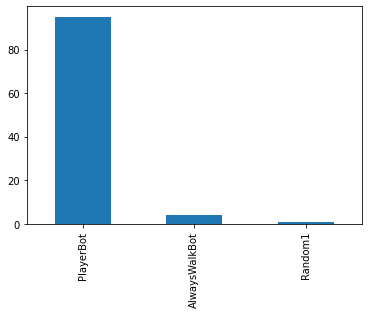

In [60]:
winners = []
n_rounds = []
for i in tqdm(range(100)):
    game = Game(bots=bots, verbose=0)
    while not game.winner:
        game.run_round()
    winners.append(game.winner)
    n_rounds.append(game.n_rounds)

pd.Series({k.name: v for k, v in Counter(winners).items()}).plot.bar()